# Testing with some Deep Learning Model

Following https://github.com/Yura52/rtdl/blob/main/examples/rtdl.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_theme()


import sys; sys.path.append("../../")
from modules.utils import load_yaml, save_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

In [2]:
from typing import Any, Dict

import numpy as np
# import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

In [3]:
device = torch.device('cuda:1')


# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [4]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']
encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [5]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

## Guided part

In [6]:
task_type = 'multiclass'
assert task_type in ['binclass', 'multiclass', 'regression']

n_classes = int(max(train_y)) + 1 if task_type == 'multiclass' else None


X = {}
y = {}
X['train'],  X['val'], X['test'] = train_X, valid_X, test_X
y['train'], y['val'],  y['test'] = train_y, valid_y, test_y

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}



### OURS convert all to float for compatibility
X = {k: v.float() for k, v in X.items()}
# y = {k: v.float() for k, v in y.items()} # not y, because this is an index

## Imbalanced learning

We should attempt something for the data imbalance: better check this out

NOTE: this simple trick seems to be working!

This will be given to the loss function

https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = torch.Tensor(compute_class_weight(class_weight='balanced', classes=np.arange(n_classes), y=train_y)).to(device)

# Train Model

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

In [8]:
from datetime import datetime, timezone, timedelta
KST = timezone(timedelta(hours=9))
PREDICT_TIMESTAMP = datetime.now(tz=KST).strftime("%Y%m%d%H%M%S")

SAVE_DIR = f'checkpoints/{PREDICT_TIMESTAMP}'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [9]:
%load_ext autoreload
%autoreload 2
from models.ft_transformer.modules import FTTransformer, MLP, ResNet

d_out = n_classes or 1
num_features = X['train'].shape[1] # change based on your application

model_config = {'n_num_features':num_features,
                'cat_cardinalities':None,
                'last_layer_query_idx':[-1],
                'd_out':d_out}

model = FTTransformer.make_default(**model_config)

# Save configuration
save_yaml(os.path.join(SAVE_DIR, 'model_config.yaml'), model_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
YAML saved checkpoints/20220609011031/model_config.yaml


'YAML saved checkpoints/20220609011031/model_config.yaml'

In [10]:
lr = 0.001
weight_decay = 0.0

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)

# Custom declaration for multiclass models
# Class weights for imbalanced learning (see above)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# loss_fn = (
#     F.binary_cross_entropy_with_logits
#     if task_type == 'binclass'
#     else F.cross_entropy
#     if task_type == 'multiclass'
#     else F.mse_loss
# )

In [11]:


def train_log(target, prediction, epoch=0):
    f1_macro = sklearn.metrics.f1_score(target, prediction, average='macro')
    f1_weighted = sklearn.metrics.f1_score(target, prediction, average='weighted')
    accuracy = sklearn.metrics.accuracy_score(target, prediction)
    wandb.log({"epoch": epoch, "f1_macro": f1_macro, "f1_weighted":f1_weighted, 'accuracy':accuracy})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jujub (use `wandb login --relogin` to force relogin)


In [12]:
def apply_model(x_num, model=model, x_cat=None):
    if isinstance(model, FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (MLP, ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )

# Only log Wandb validation
@torch.no_grad()
def evaluate(part, batch_size_eval=32, log_wandb=True, epoch=0): 
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size_eval):
        prediction.append(apply_model(batch.float()).cpu())
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.f1_score(target, prediction, average='macro') # NOTE: changed to macro F1
        # score = sklearn.metrics.accuracy_score(target, prediction)

        # Wandb Logging
        if part == 'val' and log_wandb:
            train_log(target, prediction, epoch=epoch)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 128
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test", log_wandb=False):.4f}')

Test score before training: 0.0590


In [13]:
n_epochs = 1000
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch) # NOTE: move to double
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val', epoch=epoch)
    test_score = evaluate('test', epoch=epoch)
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'best.pt')) # best checkpoint
    print()
    if progress.fail:
        break
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'last.pt')) # last checkpoint

(epoch) 1 (batch) 0 (loss) 1.7480
(epoch) 1 (batch) 42 (loss) 1.4144
(epoch) 1 (batch) 84 (loss) 1.4489
(epoch) 1 (batch) 126 (loss) 1.2304
(epoch) 1 (batch) 168 (loss) 1.2625
Epoch 001 | Validation score: 0.3558 | Test score: 0.3558 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 1.2611
(epoch) 2 (batch) 42 (loss) 1.2375
(epoch) 2 (batch) 84 (loss) 1.3433
(epoch) 2 (batch) 126 (loss) 1.1342
(epoch) 2 (batch) 168 (loss) 1.1792
Epoch 002 | Validation score: 0.3877 | Test score: 0.3877 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 1.2338
(epoch) 3 (batch) 42 (loss) 1.1866
(epoch) 3 (batch) 84 (loss) 1.1172
(epoch) 3 (batch) 126 (loss) 1.0806
(epoch) 3 (batch) 168 (loss) 1.0989
Epoch 003 | Validation score: 0.4292 | Test score: 0.4292 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 1.0886
(epoch) 4 (batch) 42 (loss) 1.2056
(epoch) 4 (batch) 84 (loss) 1.0972
(epoch) 4 (batch) 126 (loss) 1.0208
(epoch) 4 (batch) 168 (loss) 1.0191
Epoch 004 | Validation score: 0.4724 | Test 

KeyboardInterrupt: 

# Prediction

In [ ]:
def get_predictions(model=model, batch_size_eval=32):
    with torch.no_grad():
        model.eval()
        prediction = []
        for batch in zero.iter_batches(X['test'], batch_size_eval):
            prediction.append(apply_model(batch.float(), model=model).cpu())
        pred_y = torch.cat(prediction).squeeze(1).cpu().numpy()
        pred_y = pred_y.argmax(1)
    return pred_y


pred_y = get_predictions()

# Metrics evaluation

We need to get a few metrics right

In [ ]:
encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


F1 score : 0.725


,precision,recall,f1-score,support
0,0.860071,0.796988,0.827328,1527
1,0.782394,0.856988,0.817994,923
2,0.989100,0.948031,0.968130,3733
3,0.447154,0.557432,0.496241,296
4,0.435159,0.626556,0.513605,241
accuracy,0.872470,0.872470,0.872470,0
macro avg,0.702775,0.757199,0.724660,6720
weighted avg,0.887652,0.872470,0.878428,6720


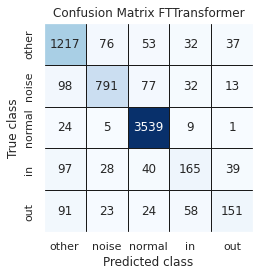

In [ ]:
model_name, y_hat = 'FTTransformer', pred_y

plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Actual test for submission

In [ ]:
# Setup
model = clf # change with the name of your model
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']


# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])

y_pred = model.predict(test_X)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)

____

# Other

In [ ]:
# Model saving
# torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'last.pt'))



# Model loading
model2_dict = torch.load(os.path.join(SAVE_DIR, 'last.pt'))


model_config = load_yaml('soff.yaml')

model2 = FTTransformer.make_default(**model_config)
model2.load_state_dict(model2_dict)
model2.eval()